In [2]:
import torch
import torch.nn as nn

In [ ]:
#Augmentations
import numpy as np
import cv2
import random

def radial_vignette(img, strength=0.2):
    """
    Apply radial vignette (simulate limb-darkening).
    strength: 0.0 (none) to 0.5 (strong)
    """
    h, w = img.shape
    y, x = np.ogrid[:h, :w]
    cy, cx = h / 2, w / 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2)
    r = r / r.max()  # normalize radius [0,1]
    
    # limb-darkening multiplier
    mask = 1 - strength * (r**2)  
    vignette = img.astype(np.float32) * mask
    vignette = np.clip(vignette, 0, 255)
    return vignette.astype(np.uint8)

def add_poisson_noise(img, scale_low=5.0, scale_high=100.0):
    """
    Add Poisson noise to simulate photon noise.
    """
    if img.dtype != np.float32:
        img = img.astype(np.float32) / 255.0
    scale = random.uniform(scale_low, scale_high)
    noisy = np.random.poisson(img * scale) / float(scale)
    noisy = np.clip(noisy, 0.0, 1.0)
    return (noisy * 255).astype(np.uint8)

def random_rotation(img, angle_range=20):
    """
    Rotate image by random angle within ±angle_range.
    """
    h, w = img.shape
    angle = random.uniform(-angle_range, angle_range)
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    return rotated

def random_crop_resize(img, crop_scale=0.8, out_size=(256, 256)):
    """
    Random crop followed by resize.
    crop_scale: fraction of original image kept (0.5–1.0).
    """
    h, w = img.shape
    ch, cw = int(h * crop_scale), int(w * crop_scale)
    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    crop = img[y:y+ch, x:x+cw]
    resized = cv2.resize(crop, out_size, interpolation=cv2.INTER_LINEAR)
    return resized

def gaussian_blur(img, sigma_range=(0.5, 2.0)):
    """
    Apply Gaussian blur with random sigma.
    """
    sigma = random.uniform(*sigma_range)
    ksize = int(2 * round(3*sigma) + 1)  # kernel size ~ 6*sigma
    blurred = cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma)
    return blurred

def brightness_contrast_jitter(img, brightness=0.2, contrast=0.3):
    """
    Random brightness/contrast adjustment.
    brightness: fraction (e.g. 0.2 → ±20%)
    contrast: fraction (e.g. 0.3 → ±30%)
    """
    b = random.uniform(-brightness, brightness) * 255
    c = 1.0 + random.uniform(-contrast, contrast)
    jittered = img.astype(np.float32) * c + b
    jittered = np.clip(jittered, 0, 255)
    return jittered.astype(np.uint8)

def random_noise(img, noise_level=0.10):
    """
    Add random Gaussian noise.
    noise_level: fraction of max pixel value (0.0–0.5)
    """
    if img.dtype != np.float32:
        img = img.astype(np.float32) / 255.0
    noise = np.random.normal(0, noise_level, img.shape)
    noisy = img + noise
    noisy = np.clip(noisy, 0.0, 1.0)
    return (noisy * 255).astype(np.uint8)

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)  # latent: [B,64,H/8,W/8]

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=1, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.deconv(x)


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)    # compress to latent vector
        reconstructed = self.decoder(latent)  # reconstruct image
        return reconstructed


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import random
import numpy as np

class SolarDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, augment=True, img_size=(256,256),max_images=None):
        self.lr_files = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir)])
        self.hr_files = sorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir)])
        if max_images is not None:
            self.lr_files = self.lr_files[:max_images]
            self.hr_files = self.hr_files[:max_images]
        self.augment = augment
        self.img_size = img_size

    def __len__(self):
        return len(self.lr_files)

    def __getitem__(self, idx):
        # Load images
        lr = cv2.imread(self.lr_files[idx], cv2.IMREAD_GRAYSCALE)
        hr = cv2.imread(self.hr_files[idx], cv2.IMREAD_GRAYSCALE)

        # Resize to same size
        lr = cv2.resize(lr, self.img_size)
        hr = cv2.resize(hr, self.img_size)

        # Apply augmentations to LR only
        if self.augment:
            lr = radial_vignette(lr, strength=random.uniform(0.05,0.2))
            lr = add_poisson_noise(lr)
            lr = random_rotation(lr, angle_range=15)
            lr = gaussian_blur(lr, sigma_range=(0.5,1.5))
            lr = brightness_contrast_jitter(lr, brightness=0.15, contrast=0.2)
            lr = random_noise(lr, noise_level=0.05)
        
        # Normalize and convert to tensor [C,H,W]
        lr = torch.tensor(lr, dtype=torch.float32).unsqueeze(0)/255.0
        hr = torch.tensor(hr, dtype=torch.float32).unsqueeze(0)/255.0

        return lr, hr


In [6]:
batch_size = 16
max_images = None  # Set to None to use all images

train_dataset = SolarDataset("new_dataset/training/low_res", 
                             "new_dataset/training/high_res", 
                             augment=True, max_images=max_images)

val_dataset = SolarDataset("new_dataset/validation/low_res", 
                           "new_dataset/validation/high_res", 
                           augment=False, max_images=max_images)

test_dataset = SolarDataset("new_dataset/testing/low_res", 
                            "new_dataset/testing/high_res", 
                            augment=False, max_images=max_images)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [2]:
torch.cuda.is_available()
# print(torch.version.cuda)

True

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import os
from torchvision import transforms
from torchmetrics.functional import structural_similarity_index_measure as ssim

# -----------------------------
# Metrics
# -----------------------------
def pixelwise_error(pred, target):
    return torch.mean(torch.abs(pred - target)).item()

def psnr(pred, target, max_val=1.0):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(max_val / torch.sqrt(mse)).item()


def ssim_metric(pred, target):
    return ssim(pred, target, data_range=1.0).item()  

# -----------------------------
# Hyperparameters
# -----------------------------
batch_size = 8
lr = 1e-3
epochs = 20
latent_dim = 128

# -----------------------------
# Model, Loss, Optimizer
# -----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# -----------------------------
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_loss = float('inf')
bottleneck_embeddings = []

# -----------------------------
# Training Loop
# -----------------------------
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(lr_imgs)
        loss = criterion(outputs, hr_imgs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * lr_imgs.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    pixel_err = 0
    psnr_val = 0
    ssim_val = 0

    with torch.no_grad():
        for lr_imgs, hr_imgs in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

            outputs = model(lr_imgs)
            loss = criterion(outputs, hr_imgs)
            val_loss += loss.item() * lr_imgs.size(0)

            pixel_err += pixelwise_error(outputs, hr_imgs) * lr_imgs.size(0)
            psnr_val += psnr(outputs, hr_imgs) * lr_imgs.size(0)
            ssim_val += ssim_metric(outputs, hr_imgs) * lr_imgs.size(0)

            # Save bottleneck embeddings
            latent = model.encoder(lr_imgs)
            bottleneck_embeddings.append(latent.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    pixel_err /= len(val_loader.dataset)
    psnr_val /= len(val_loader.dataset)
    ssim_val /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.6f} | "
          f"Val Loss: {val_loss:.6f} | "
          f"Pixel Error: {pixel_err:.6f} | "
          f"PSNR: {psnr_val:.2f} dB | "
          f"SSIM: {ssim_val:.4f}")

    # -----------------------------
    # Save checkpoints
    # -----------------------------
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"autoencoder_epoch{epoch+1}.pth"))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_autoencoder.pth"))
        print(f"Best model updated at epoch {epoch+1}")

# Save bottleneck embeddings
bottleneck_embeddings = np.concatenate(bottleneck_embeddings, axis=0)
np.save("bottleneck_embeddings.npy", bottleneck_embeddings)
print("Bottleneck embeddings saved:", bottleneck_embeddings.shape)


Epoch 1/20 [Val]:   0%|          | 0/78 [00:00<?, ?it/s]c:\Users\Kartik\anaconda3\envs\SolaRes\Lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
Epoch 1/20 [Val]: 100%|██████████| 78/78 [00:15<00:00,  5.06it/s]


Epoch 1/20 | Train Loss: 0.010565 | Val Loss: 0.008236 | Pixel Error: 0.062240 | PSNR: 20.91 dB | SSIM: 0.2354
Best model updated at epoch 1


Epoch 2/20 [Val]: 100%|██████████| 78/78 [00:07<00:00, 10.53it/s]


Epoch 2/20 | Train Loss: 0.009818 | Val Loss: 0.007864 | Pixel Error: 0.061638 | PSNR: 21.11 dB | SSIM: 0.2372
Best model updated at epoch 2


Epoch 3/20 [Val]: 100%|██████████| 78/78 [00:07<00:00, 10.99it/s]


Epoch 3/20 | Train Loss: 0.009547 | Val Loss: 0.007519 | Pixel Error: 0.061236 | PSNR: 21.30 dB | SSIM: 0.2395
Best model updated at epoch 3


Epoch 4/20 [Val]: 100%|██████████| 78/78 [00:07<00:00, 11.00it/s]


Epoch 4/20 | Train Loss: 0.009365 | Val Loss: 0.007402 | Pixel Error: 0.060702 | PSNR: 21.36 dB | SSIM: 0.2408
Best model updated at epoch 4


Epoch 5/20 [Val]: 100%|██████████| 78/78 [00:06<00:00, 12.00it/s]


Epoch 5/20 | Train Loss: 0.009306 | Val Loss: 0.007218 | Pixel Error: 0.060439 | PSNR: 21.47 dB | SSIM: 0.2429
Best model updated at epoch 5


Epoch 6/20 [Val]: 100%|██████████| 78/78 [00:09<00:00,  8.11it/s]


Epoch 6/20 | Train Loss: 0.009257 | Val Loss: 0.007066 | Pixel Error: 0.059874 | PSNR: 21.56 dB | SSIM: 0.2448
Best model updated at epoch 6


Epoch 7/20 [Val]: 100%|██████████| 78/78 [00:07<00:00, 10.44it/s]


Epoch 7/20 | Train Loss: 0.009189 | Val Loss: 0.007210 | Pixel Error: 0.060136 | PSNR: 21.47 dB | SSIM: 0.2433


Epoch 8/20 [Val]: 100%|██████████| 78/78 [00:05<00:00, 15.40it/s]


Epoch 8/20 | Train Loss: 0.009187 | Val Loss: 0.007172 | Pixel Error: 0.060136 | PSNR: 21.50 dB | SSIM: 0.2430


Epoch 9/20 [Val]: 100%|██████████| 78/78 [00:05<00:00, 13.44it/s]


Epoch 9/20 | Train Loss: 0.009088 | Val Loss: 0.006800 | Pixel Error: 0.059211 | PSNR: 21.72 dB | SSIM: 0.2486
Best model updated at epoch 9


Epoch 10/20 [Val]: 100%|██████████| 78/78 [00:04<00:00, 15.90it/s]


Epoch 10/20 | Train Loss: 0.009107 | Val Loss: 0.007019 | Pixel Error: 0.059426 | PSNR: 21.59 dB | SSIM: 0.2464


Epoch 11/20 [Val]: 100%|██████████| 78/78 [00:04<00:00, 16.15it/s]


Epoch 11/20 | Train Loss: 0.009059 | Val Loss: 0.006934 | Pixel Error: 0.059574 | PSNR: 21.64 dB | SSIM: 0.2461


Epoch 12/20 [Val]: 100%|██████████| 78/78 [00:04<00:00, 15.68it/s]


Epoch 12/20 | Train Loss: 0.009057 | Val Loss: 0.006913 | Pixel Error: 0.059454 | PSNR: 21.65 dB | SSIM: 0.2483


Epoch 13/20 [Val]: 100%|██████████| 78/78 [00:05<00:00, 15.39it/s]


Epoch 13/20 | Train Loss: 0.009082 | Val Loss: 0.007287 | Pixel Error: 0.060243 | PSNR: 21.43 dB | SSIM: 0.2439


Epoch 14/20 [Val]: 100%|██████████| 78/78 [00:06<00:00, 12.43it/s]


Epoch 14/20 | Train Loss: 0.009048 | Val Loss: 0.007214 | Pixel Error: 0.060078 | PSNR: 21.48 dB | SSIM: 0.2465


Epoch 15/20 [Val]: 100%|██████████| 78/78 [00:04<00:00, 17.29it/s]


Epoch 15/20 | Train Loss: 0.008999 | Val Loss: 0.007240 | Pixel Error: 0.060033 | PSNR: 21.46 dB | SSIM: 0.2447


Epoch 16/20 [Val]: 100%|██████████| 78/78 [00:04<00:00, 16.02it/s]


Epoch 16/20 | Train Loss: 0.008985 | Val Loss: 0.007028 | Pixel Error: 0.059595 | PSNR: 21.59 dB | SSIM: 0.2471


Epoch 17/20 [Val]: 100%|██████████| 78/78 [00:04<00:00, 15.77it/s]


Epoch 17/20 | Train Loss: 0.008974 | Val Loss: 0.007278 | Pixel Error: 0.060465 | PSNR: 21.44 dB | SSIM: 0.2450


Epoch 18/20 [Train]:  16%|█▌        | 62/388 [00:13<01:27,  3.72it/s]

: 

Testing:   0%|          | 0/52 [00:00<?, ?it/s]c:\Users\Kartik\anaconda3\envs\SolaRes\Lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


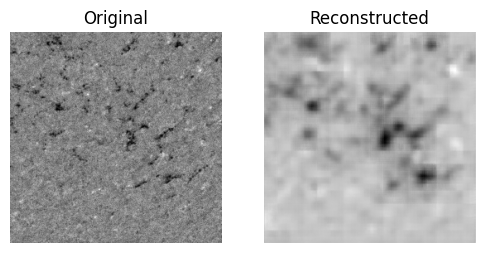

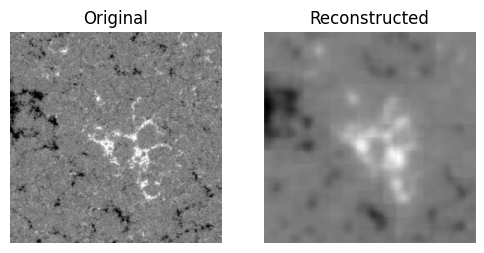

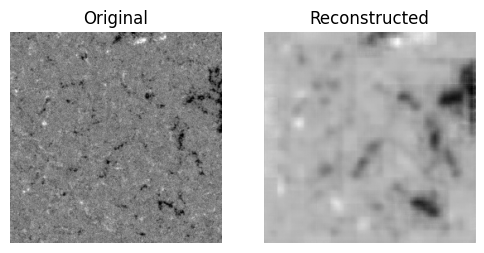

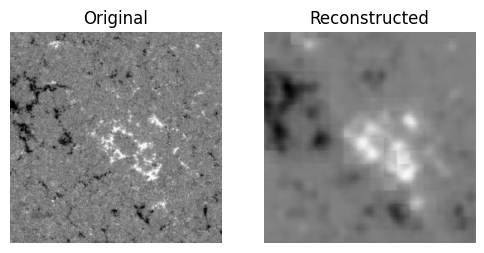

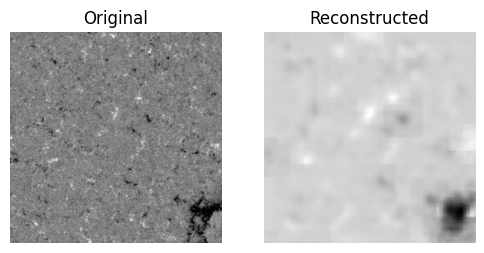

Testing: 100%|██████████| 52/52 [00:23<00:00,  2.26it/s]

Average PSNR: 21.80 dB
Average SSIM: 0.2486
Average Pixel Error: 0.059230
Reconstructed images saved in 'reconstructed_images/' folder


In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics.functional import structural_similarity_index_measure as ssim
import os

# -----------------------------
# Metrics
# -----------------------------
def pixelwise_error(pred, target):
    return torch.mean(torch.abs(pred - target)).item()

def psnr(pred, target, max_val=1.0):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(max_val / torch.sqrt(mse)).item()

def ssim_metric(pred, target):
    return ssim(pred, target, data_range=1.0).item()

# -----------------------------
# Load model
# -----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Autoencoder().to(device)
model.load_state_dict(torch.load("checkpoints/best_autoencoder.pth"))
model.eval()

# Directory to save reconstructed images
os.makedirs("reconstructed_images", exist_ok=True)

# -----------------------------
# Testing and Visualization
# -----------------------------
psnr_list = []
ssim_list = []
pixel_err_list = []

count = 0  # to limit visualization
for lr_imgs, hr_imgs in tqdm(test_loader, desc="Testing"):
    lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
    with torch.no_grad():
        outputs = model(lr_imgs)
    
    for i in range(lr_imgs.size(0)):
    # Move to CPU and convert to float
        pred_img = outputs[i].detach().cpu().float()
        true_img = hr_imgs[i].detach().cpu().float()

    # Add channel dimension for SSIM: [1, 1, H, W]
        pred_img_ssim = pred_img.unsqueeze(0)  # shape: [1, 1, H, W]
        true_img_ssim = true_img.unsqueeze(0)  # shape: [1, 1, H, W]

    # Metrics
        psnr_list.append(psnr(pred_img, true_img))
        ssim_list.append(ssim_metric(pred_img_ssim, true_img_ssim))
        pixel_err_list.append(pixelwise_error(pred_img, true_img))
        
        # Save reconstructed image
        recon_img_path = f"reconstructed_images/recon_{count}.png"
        plt.imsave(recon_img_path, pred_img.squeeze(), cmap='gray')
        
        # Display side by side for first 5 images
        if count < 5:
            fig, axes = plt.subplots(1,2, figsize=(6,3))
            axes[0].imshow(true_img.squeeze(), cmap='gray')
            axes[0].set_title("Original")
            axes[0].axis('off')
            axes[1].imshow(pred_img.squeeze(), cmap='gray')
            axes[1].set_title("Reconstructed")
            axes[1].axis('off')
            plt.show()
        
        count += 1


print(f"Average PSNR: {np.mean(psnr_list):.2f} dB")
print(f"Average SSIM: {np.mean(ssim_list):.4f}")
print(f"Average Pixel Error: {np.mean(pixel_err_list):.6f}")
print(f"Reconstructed images saved in 'reconstructed_images/' folder")
